In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code_prophet/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%run 1_preprocessing_data.ipynb

In [3]:
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


PROPHET

In [4]:
# ============================================================================
# PASO 1: Preparación de datos y creación de series_id
# ============================================================================

# Convertir date a datetime si no lo está
data['date'] = pd.to_datetime(data['date'])

# Crear series_id combinando brand + supermarket + variant + pack_size
data['series_id'] = (
    data['brand'].astype(str) + '_' + 
    data['supermarket'].astype(str) + '_' + 
    data['variant'].astype(str) + '_' + 
    data['pack.size'].astype(str)
)

# Ordenar por series_id y date
data = data.sort_values(['series_id', 'date']).reset_index(drop=True)

print(f"Número de series únicas: {data['series_id'].nunique()}")
print(f"Series ID ejemplo: {data['series_id'].iloc[0]}")
print(f"Rango de fechas: {data['date'].min()} a {data['date'].max()}")

Número de series únicas: 143
Series ID ejemplo: brand-14_supermarket-A_flavoured_0 - 350 GR
Rango de fechas: 2021-01-31 00:00:00 a 2023-12-31 00:00:00


In [5]:
# ============================================================================
# PASO 2: Split temporal
# ============================================================================

# Fijar fechas explícitamente (igual que CatBoost)
# Split basado en fecha, no en índice de filas

train_cutoff = pd.Timestamp('2023-06-30')
test_start = pd.Timestamp('2023-07-01')
test_end = pd.Timestamp('2023-12-31')

train_data = data[data['date'] <= train_cutoff].copy()
test_data = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()

print(f"Train: {len(train_data)} filas, desde {train_data['date'].min()} hasta {train_data['date'].max()}")
print(f"Test: {len(test_data)} filas, desde {test_data['date'].min()} hasta {test_data['date'].max()}")
print(f"Número de series en train: {train_data['series_id'].nunique()}")
print(f"Número de series en test: {test_data['series_id'].nunique()}")

#FIXME: predecir solo las series que tengan datos en test

Train: 3579 filas, desde 2021-01-31 00:00:00 hasta 2023-06-30 00:00:00
Test: 727 filas, desde 2023-07-31 00:00:00 hasta 2023-12-31 00:00:00
Número de series en train: 143
Número de series en test: 132


In [6]:
# ============================================================================
# PASO 3: Quedarnos solo con las series que tienen datos en test
# ============================================================================

# Nos quedamos solo con las series que tienen datos en test
series_with_data_in_test = test_data['series_id'].unique()
train_data = train_data[train_data['series_id'].isin(series_with_data_in_test)]

print(f"Series evaluadas (presentes en test): {len(series_with_data_in_test)}")
print(f"Train tras filtrar: {train_data['series_id'].nunique()} series")
print(f"Test tras filtrar: {test_data['series_id'].nunique()} series")


Series evaluadas (presentes en test): 132
Train tras filtrar: 132 series
Test tras filtrar: 132 series


In [7]:
# ============================================================================
# PASO 4: Entrenar Prophet
# ============================================================================

def prepare_data_prophet(df_one_series):

    df = df_one_series.sort_values('date').copy()

   # Agregar por mes por si hubiera duplicados (seguridad)
    agg_dict = {"volume.sales": "sum"}
    for r in ["price"]:
        agg_dict[r] = "mean"  # o "last" si el precio es del final de mes

    df = df.groupby("date", as_index=False).agg(agg_dict)
    
    df = df.set_index("date").asfreq("M")
    # Opciones para missing:
    # - target: si falta un mes, puede ser 0 ventas o missing real. Ajusta según negocio.
    # Aquí: dejamos NaN y luego lo tratamos (Prophet no acepta y NaN en train).

    # Reindex mensual (Month Start). Si tu date ya es fin de mes, ajusta a "M".

    for r in ["price"]:
        if r in df.columns:
            df[r] = df[r].ffill()

    df = df.reset_index().rename(columns={"date": "ds", "volume.sales": "y"})

    return df


In [43]:
serie_example = test_data["series_id"].iloc[40]
serie_example = "brand-14_supermarket-A_vegan_351 - 500 GR"
print(serie_example)
train_series = train_data[train_data["series_id"] == serie_example]

brand-14_supermarket-A_vegan_351 - 500 GR


Filtrado por marca: brand-14
Filtrado por supermercado: supermarket-A
Filtrado por variante: vegan
Filtrado por tamaño: 351 - 500 GR

Total de series a plotear: 1
Gráfico 1/1 completado: brand-14_supermarket-A_vegan_351 - 500 GR


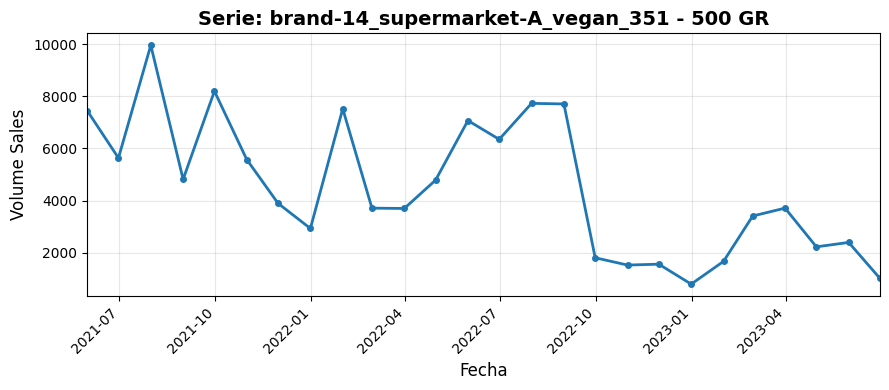

15:20:48 - cmdstanpy - INFO - Chain [1] start processing



✅ Se han generado 1 gráficos individuales


15:20:49 - cmdstanpy - INFO - Chain [1] done processing


          ds       y          yhat    yhat_lower    yhat_upper
0 2023-07-31  163.80  32851.862265  32851.583757  32852.143642
1 2023-08-31   54.99  16456.738062  16455.819874  16457.650028
2 2023-09-30   19.89  21598.593863  21596.930957  21600.387928
3 2023-10-31    8.97  18407.793303  18405.026010  18410.421386
4 2023-11-30     NaN  32175.248212  32171.289430  32179.035561
5 2023-12-31    1.56 -26081.474210 -26086.880235 -26076.334909
MAE: 23030.074340646253
MAPE (%): 407075.5080089328
RMSE: 23757.140345891636


In [44]:
# ----------------------------------------------------------------------------
import sys

sys.path.append("../new_models")
from plot_every_series import plot_every_series

plot_every_series(
    train_series,
    filter_brand="brand-14",
    filter_supermarket="supermarket-A",
    filter_variant="vegan",
    filter_pack_size="351 - 500 GR",
)

# ----------------------------------------------------------------------------

train_series = train_data[train_data["series_id"] == serie_example]
test_series = test_data[test_data["series_id"] == serie_example]

df_train = prepare_data_prophet(train_series)
df_test = prepare_data_prophet(test_series)

df_train = df_train.dropna(subset=["y"]).copy()

# Crear modelo Prophet
model = Prophet(
    yearly_seasonality=20,
    # yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    # seasonality_mode="multiplicative", #TODO: funciona con tranformación de logaritmo, el additivo no funciona con esto
    seasonality_mode="additive",
    # changepoint_prior_scale=0.05,
    # seasonality_prior_scale=10,
    # interval_width=0.80,
    # changepoints=None,
    # mcmc_samples=0,
)

price_mean = df_train["price"].mean()
price_std = df_train["price"].std()
df_train["price_normalized"] = (df_train["price"] - price_mean) / price_std
df_test["price_normalized"] = (df_test["price"] - price_mean) / price_std

model.add_regressor("price_normalized")
# model.add_regressor("price")

# df_train["y"] = np.log1p(df_train["y"])

model.fit(df_train)

# Para predecir, el dataframe debe tener ds + regresores (si los usaste)
# future = df_test[["ds"] + ["price"]].copy()
future = df_test[["ds"] + ["price_normalized"]].copy()

forecast = model.predict(future)

# # Aplicar la transformación inversa a las predicciones
# forecast["yhat"] = np.expm1(forecast["yhat"])
# forecast["yhat_lower"] = np.expm1(forecast["yhat_lower"])
# forecast["yhat_upper"] = np.expm1(forecast["yhat_upper"])

# Unir con real para comparar
pred_df = df_test[["ds", "y"]].merge(
    forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left"
)

print(pred_df.head(12))


def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred) & (y_true != 0)
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("MAE:", mae(pred_df["y"], pred_df["yhat"]))
print("MAPE (%):", mape(pred_df["y"], pred_df["yhat"]))
print("RMSE:", rmse(pred_df["y"], pred_df["yhat"]))

# # Evaluar en escala log (más justo)
# # forecast no tiene columna 'y', así que usamos los reales de test transformados a log
# mae_log = mae(np.log1p(df_test["y"]), np.log1p(forecast["yhat"]))
# print(f"MAE en escala log: {mae_log}")

In [30]:
# ============================================================================
# PASO 5: Entrenar Prophet para TODAS las series y calcular métricas
# ============================================================================

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))


def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred) & (y_true != 0)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# Almacenar resultados
results = []
all_predictions = []

# Obtener todas las series únicas
all_series = sorted(series_with_data_in_test)

print(f"Entrenando Prophet para {len(all_series)} series...")
print("=" * 80)

for idx, serie_id in enumerate(all_series, 1):
    try:
        # Obtener datos de train y test para esta serie
        train_series = train_data[train_data["series_id"] == serie_id].copy()
        test_series = test_data[test_data["series_id"] == serie_id].copy()
        
        if len(train_series) == 0 or len(test_series) == 0:
            print(f"[{idx}/{len(all_series)}] {serie_id}: Sin datos suficientes, saltando...")
            continue
        
        # Preparar datos para Prophet
        df_train = prepare_data_prophet(train_series)
        df_test = prepare_data_prophet(test_series)
        
        # Eliminar NaN en y para entrenamiento
        df_train = df_train.dropna(subset=["y"]).copy()
        
        if len(df_train) < 3:  # Mínimo de datos para Prophet
            print(f"[{idx}/{len(all_series)}] {serie_id}: Datos insuficientes para entrenar (< 3 puntos), saltando...")
            continue
        
        # Normalizar precio
        price_mean = df_train["price"].mean()
        price_std = df_train["price"].std()
        
        if price_std == 0 or np.isnan(price_std):
            # Si no hay variación en precio, no usar como regresor
            df_train["price_normalized"] = 0
            df_test["price_normalized"] = 0
            use_price_regressor = False
        else:
            df_train["price_normalized"] = (df_train["price"] - price_mean) / price_std
            df_test["price_normalized"] = (df_test["price"] - price_mean) / price_std
            use_price_regressor = True
        
        # Crear y entrenar modelo Prophet
        model = Prophet(
            yearly_seasonality=20,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode="additive",
        )
        
        if use_price_regressor:
            model.add_regressor("price_normalized")
        
        model.fit(df_train)
        
        # Preparar futuro para predicción
        if use_price_regressor:
            future = df_test[["ds", "price_normalized"]].copy()
        else:
            future = df_test[["ds"]].copy()
        
        # Predecir
        forecast = model.predict(future)
        
        # Unir predicciones con valores reales
        pred_df = df_test[["ds", "y"]].merge(
            forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], 
            on="ds", 
            how="left"
        )
        
        # Calcular métricas
        mae_val = mae(pred_df["y"], pred_df["yhat"])
        rmse_val = rmse(pred_df["y"], pred_df["yhat"])
        mape_val = mape(pred_df["y"], pred_df["yhat"])
        
        # Guardar resultados
        results.append({
            "series_id": serie_id,
            "mae": mae_val,
            "rmse": rmse_val,
            "mape": mape_val,
            "n_train": len(df_train),
            "n_test": len(df_test),
            "mean_y_train": df_train["y"].mean(),
            "mean_y_test": df_test["y"].mean(),
            "mean_yhat": pred_df["yhat"].mean(),
        })
        
        # Guardar predicciones detalladas
        pred_df["series_id"] = serie_id
        all_predictions.append(pred_df)
        
        if idx % 10 == 0 or idx == len(all_series):
            print(f"[{idx}/{len(all_series)}] Completado: {serie_id[:50]}... | MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}")
    
    except Exception as e:
        print(f"[{idx}/{len(all_series)}] ERROR en {serie_id}: {str(e)}")
        results.append({
            "series_id": serie_id,
            "mae": np.nan,
            "rmse": np.nan,
            "mape": np.nan,
            "n_train": len(train_series) if 'train_series' in locals() else 0,
            "n_test": len(test_series) if 'test_series' in locals() else 0,
            "error": str(e),
        })
        continue

print("=" * 80)
print("Entrenamiento completado!")

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

# Concatenar todas las predicciones
predictions_df = pd.concat(all_predictions, ignore_index=True) if all_predictions else pd.DataFrame()

# ============================================================================
# ANÁLISIS DE MÉTRICAS
# ============================================================================

print("\n" + "=" * 80)
print("RESUMEN DE MÉTRICAS")
print("=" * 80)

# Métricas agregadas (excluyendo NaN)
valid_results = results_df.dropna(subset=["mae", "rmse"])

if len(valid_results) > 0:
    print(f"\nSeries procesadas exitosamente: {len(valid_results)}/{len(results_df)}")
    print(f"\nMétricas promedio:")
    print(f"  MAE promedio:  {valid_results['mae'].mean():.2f}")
    print(f"  RMSE promedio: {valid_results['rmse'].mean():.2f}")
    print(f"  MAPE promedio: {valid_results['mape'].mean():.2f}%")
    
    print(f"\nMétricas medianas:")
    print(f"  MAE mediana:  {valid_results['mae'].median():.2f}")
    print(f"  RMSE mediana: {valid_results['rmse'].median():.2f}")
    print(f"  MAPE mediana: {valid_results['mape'].median():.2f}%")
    
    print(f"\nMétricas por percentiles:")
    print(f"  MAE  P25: {valid_results['mae'].quantile(0.25):.2f}")
    print(f"  MAE  P75: {valid_results['mae'].quantile(0.75):.2f}")
    print(f"  RMSE P25: {valid_results['rmse'].quantile(0.25):.2f}")
    print(f"  RMSE P75: {valid_results['rmse'].quantile(0.75):.2f}")
    
    print(f"\nMejores y peores series (por MAE):")
    print("\nTop 5 mejores (menor MAE):")
    top5 = valid_results.nsmallest(5, "mae")[["series_id", "mae", "rmse", "mape"]]
    for _, row in top5.iterrows():
        print(f"  {row['series_id'][:60]:60s} | MAE: {row['mae']:8.2f} | RMSE: {row['rmse']:8.2f} | MAPE: {row['mape']:6.2f}%")
    
    print("\nTop 5 peores (mayor MAE):")
    worst5 = valid_results.nlargest(5, "mae")[["series_id", "mae", "rmse", "mape"]]
    for _, row in worst5.iterrows():
        print(f"  {row['series_id'][:60]:60s} | MAE: {row['mae']:8.2f} | RMSE: {row['rmse']:8.2f} | MAPE: {row['mape']:6.2f}%")
else:
    print("No hay resultados válidos para analizar.")

# Mostrar primeras filas de resultados
print("\n" + "=" * 80)
print("Primeras 10 filas de resultados:")
print("=" * 80)
print(results_df.head(10).to_string())

# Guardar resultados en variables para uso posterior
print("\n" + "=" * 80)
print("Resultados guardados en:")
print("  - results_df: DataFrame con métricas por serie")
print("  - predictions_df: DataFrame con todas las predicciones detalladas")
print("=" * 80)

14:27:19 - cmdstanpy - INFO - Chain [1] start processing


Entrenando Prophet para 132 series...


14:27:23 - cmdstanpy - INFO - Chain [1] done processing
14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing
14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:30 - cmdstanpy - INFO - Chain [1] done processing
14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing
14:27:32 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:33 - cmdstanpy - INFO - Chain [1] 

[10/132] Completado: brand-14_supermarket-A_vegan_351 - 500 GR... | MAE: 23030.07, RMSE: 23757.14
[11/132] brand-14_supermarket-A_vegan_701 - 1000 GR: Datos insuficientes para entrenar (< 3 puntos), saltando...


14:27:36 - cmdstanpy - INFO - Chain [1] done processing
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:44 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing


[20/132] Completado: brand-14_supermarket-B_vegan_701 - 1000 GR... | MAE: 34068.36, RMSE: 65602.71


14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] 

[30/132] Completado: brand-14_supermarket-D_flavoured_0 - 350 GR... | MAE: 9717.53, RMSE: 13443.86


14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing
14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:56 - cmdstanpy - INFO - Chain [1] done processing
14:27:56 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:59 - cmdstanpy - INFO - Chain [1] 

[40/132] Completado: brand-14_supermarket-D_vegan_701 - 1000 GR... | MAE: 335413.51, RMSE: 373425.48


14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing
14:28:02 - cmdstanpy - INFO - Chain [1] start processing
14:28:03 - cmdstanpy - INFO - Chain [1] done processing
14:28:03 - cmdstanpy - INFO - Chain [1] start processing
14:28:09 - cmdstanpy - INFO - Chain [1] done processing
14:28:09 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:15 - cmdstanpy - INFO - Chain [1] done processing
14:28:15 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing
14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing
14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] 

[50/132] Completado: brand-15_supermarket-A_vegan_0 - 350 GR... | MAE: 2104.20, RMSE: 2595.48


14:28:34 - cmdstanpy - INFO - Chain [1] done processing
14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing
14:28:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:01 - cmdstanpy - INFO - Chain [1] done processing
14:29:01 - cmdstanpy - INFO - Chain [1] 

[60/132] Completado: brand-15_supermarket-B_standard_701 - 1000 GR... | MAE: 28997.97, RMSE: 31533.22


14:29:08 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:09 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:12 - cmdstanpy - INFO - Chain [1] done processing
14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing
14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] 

[70/132] Completado: brand-15_supermarket-C_standard_501 - 700 GR... | MAE: 69790.79, RMSE: 73881.35


14:29:22 - cmdstanpy - INFO - Chain [1] done processing
14:29:22 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing
14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:31 - cmdstanpy - INFO - Chain [1] done processing
14:29:31 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing
14:29:39 - cmdstanpy - INFO - Chain [1] 

[80/132] Completado: brand-15_supermarket-D_standard_351 - 500 GR... | MAE: 58277.76, RMSE: 74478.27


14:29:43 - cmdstanpy - INFO - Chain [1] done processing
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] 

[90/132] Completado: brand-35_supermarket-B_light_351 - 500 GR... | MAE: 38836.63, RMSE: 48091.34


14:29:49 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing
14:29:55 - cmdstanpy - INFO - Chain [1] start processing
14:29:58 - cmdstanpy - INFO - Chain [1] done processing
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing
14:30:07 - cmdstanpy - INFO - Chain [1] 

[100/132] Completado: brand-35_supermarket-C_standard_0 - 350 GR... | MAE: 2652.73, RMSE: 3112.44


14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing
14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing


[105/132] brand-35_supermarket-D_standard_0 - 350 GR: Datos insuficientes para entrenar (< 3 puntos), saltando...


14:30:24 - cmdstanpy - INFO - Chain [1] done processing
14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing


[110/132] Completado: other_supermarket-A_light_351 - 500 GR... | MAE: 3753324.22, RMSE: 3806274.44


14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing
14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] 

[120/132] Completado: other_supermarket-B_vegan_0 - 350 GR... | MAE: 553.62, RMSE: 680.69


14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:55 - cmdstanpy - INFO - Chain [1] start processing
14:30:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] 

[130/132] Completado: other_supermarket-D_standard_0 - 350 GR... | MAE: 3263.58, RMSE: 4210.48


14:31:15 - cmdstanpy - INFO - Chain [1] done processing


[132/132] Completado: other_supermarket-D_standard_501 - 700 GR... | MAE: 35629.44, RMSE: 37572.48
Entrenamiento completado!

RESUMEN DE MÉTRICAS

Series procesadas exitosamente: 130/130

Métricas promedio:
  MAE promedio:  62076.85
  RMSE promedio: 68838.94
  MAPE promedio: 853577.45%

Métricas medianas:
  MAE mediana:  14143.85
  RMSE mediana: 18248.99
  MAPE mediana: 91.50%

Métricas por percentiles:
  MAE  P25: 4756.92
  MAE  P75: 36323.29
  RMSE P25: 5874.14
  RMSE P75: 46882.07

Mejores y peores series (por MAE):

Top 5 mejores (menor MAE):
  brand-35_supermarket-B_standard_0 - 350 GR                   | MAE:     0.55 | RMSE:     0.60 | MAPE: 335.66%
  brand-15_supermarket-C_light_0 - 350 GR                      | MAE:     1.67 | RMSE:     1.67 | MAPE: 668.76%
  brand-35_supermarket-C_light_0 - 350 GR                      | MAE:     1.70 | RMSE:     1.70 | MAPE: 678.25%
  brand-15_supermarket-B_light_0 - 350 GR                      | MAE:     5.03 | RMSE:     6.82 | MAPE: 2455.94